# Import and misc

In [1]:
from IPython.display import clear_output

In [2]:
# Instal latest torch and torchaudio

In [317]:
!pip install wandb
!pip install thop
!pip install yadisk
clear_output()

In [4]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz
!rm -f speech_commands_v0.01.tar.gz
clear_output()

In [5]:
!git clone https://github.com/mak-corp/kws_project.git

Cloning into 'kws_project'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 35 (delta 11), reused 25 (delta 5), pack-reused 0
Unpacking objects: 100% (35/35), done.


In [6]:
!git config --global user.email "you@example.com"
!git config --global user.name "Your Name"

In [270]:
!cd kws_project && git stash && git pull

No local changes to save
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/mak-corp/kws_project
   6430d33..1149a1b  main       -> origin/main
Updating 6430d33..1149a1b
Fast-forward
 metrics.py | 15 +++++++++++++++
 1 file changed, 15 insertions(+)


In [8]:
# from google.colab import drive
# import os

# drive.mount('/content/drive')
# os.symlink('/content/drive/MyDrive/Colab Notebooks/DLA/KWS_checkpoints', '/content/checkpoints')

Mounted at /content/drive


In [318]:
import yadisk
y = yadisk.YaDisk()
y.download_public('https://disk.yandex.ru/d/GEtA1T7USGfRgw', 'checkpoints.zip')

In [320]:
!unzip checkpoints.zip
!mv KWS_checkpoints checkpoints
!rm -f checkpoints.zip
clear_output()

In [9]:
%load_ext autoreload

In [10]:
from typing import Tuple, Union, List, Callable, Optional, Dict
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_
from IPython.display import clear_output

from collections import defaultdict

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [20, 7]
%config InlineBackend.figure_format = 'retina'

In [271]:
%autoreload 2

from kws_project.augmentations import AugsCreation
from kws_project.dataset import SpeechCommandDataset, Collator, get_weighted_random_sampler
from kws_project.trainer import Trainer
from kws_project.melspec import LogMelspec
from kws_project.random_seed import set_random_seed

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [13]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    rnn_type: str = "gru"
    rnn_hidden_size: int = 64
    rnn_num_layers: int = 2
    rnn_dropout: float = 0.1
    rnn_bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [14]:
set_random_seed(42)

In [15]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [16]:
dataset.csv.sample(5)

,path,keyword,label
50866,speech_commands/two/f4cae173_nohash_0.wav,two,0
1003,speech_commands/happy/d3a18257_nohash_1.wav,happy,0
38126,speech_commands/right/471a0925_nohash_0.wav,right,0
144,speech_commands/happy/518588b6_nohash_1.wav,happy,0
31651,speech_commands/go/5588c7e6_nohash_0.wav,go,0


In [17]:
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [18]:
noise_paths = [
    'speech_commands/_background_noise_/white_noise.wav',
    'speech_commands/_background_noise_/dude_miaowing.wav',
    'speech_commands/_background_noise_/doing_the_dishes.wav',
    'speech_commands/_background_noise_/exercise_bike.wav',
    'speech_commands/_background_noise_/pink_noise.wav',
    'speech_commands/_background_noise_/running_tap.wav'
]

# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation(noise_paths))
val_set = SpeechCommandDataset(csv=val_df)

In [19]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.
train_sampler = get_weighted_random_sampler(train_set.csv['label'].values)
train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

# Model

In [20]:
def count_model_parameters(model):
    return sum([p.numel() for p in model.parameters()])

In [64]:
import tempfile
from thop import profile
import copy


def get_macs_and_params(model):
    melspec = LogMelspec(config.sample_rate, config.n_mels, torch.device('cpu'), is_train=False)
    input = melspec(torch.randn(1, 16000 * 2))
    macs, params = profile(copy.deepcopy(model).to(torch.float32), (input, ))  # -> (6.0 MACs, 3.0 parameters)
    return int(macs), int(params)


def get_size_in_megabytes(model):
    # https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html#look-at-model-size
    with tempfile.TemporaryFile() as f:
        torch.save(model.state_dict(), f)
        size = f.tell() / 2**20
    return size

def evaluate_compression(base_model, compressed_model, display=True):
    base_model = base_model.cpu()
    compressed_model = compressed_model.cpu()
    
    base_mb = get_size_in_megabytes(base_model)
    compressed_mb = get_size_in_megabytes(compressed_model)

    base_macs, base_params = get_macs_and_params(base_model)
    compressed_macs, compressed_params = get_macs_and_params(compressed_model)

    compression_rate = base_mb / compressed_mb
    speed_up_rate = base_macs / compressed_macs
    grade = 3.5 * (min(compression_rate, 10.) / 10) + 3.5 * (min(speed_up_rate, 10.) / 10)

    if display:
        print()
        print("Base MB:", base_mb)
        print("Compressed MB:", compressed_mb)
        print("Memory compression rate:", compression_rate)

        print()
        print("Base MACs:", base_macs)
        print("Compressed MACs:", compressed_macs)
        print("MACs compression rate:", speed_up_rate)

        print()
        print("Base params:", base_params)
        print("Compressed params:", compressed_params)
        print("Params compression rate:", base_params / compressed_params)

        print()
        print("Grade: %0.2f / 7.00" % grade)

    return {
        "base_mb": base_mb,
        "compressed_mb": compressed_mb,
        "memory_cr": base_mb / compressed_mb,

        "base_macs": base_macs,
        "compressed_macs": compressed_macs,
        "macs_cr": base_macs / compressed_macs,

        "base_params": base_params,
        "compressed_params": compressed_params,
        "params_cr": base_params / compressed_params,

        "grade": grade,
    }

In [22]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)


class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        self.conv_out_size = self.conv_out_frequency * config.cnn_out_channels
        
        if config.rnn_type == "gru":
            self.gru = nn.GRU(
                input_size=self.conv_out_size,
                hidden_size=config.rnn_hidden_size,
                num_layers=config.rnn_num_layers,
                dropout=config.rnn_dropout,
                bidirectional=config.rnn_bidirectional,
                batch_first=True
            )
        elif config.rnn_type == "rnn":
            self.gru = nn.RNN(
                input_size=self.conv_out_size,
                hidden_size=config.rnn_hidden_size,
                num_layers=config.rnn_num_layers,
                dropout=config.rnn_dropout,
                bidirectional=config.rnn_bidirectional,
                batch_first=True
            )
        else:
            raise ValueError

        self.attention = Attention(config.rnn_hidden_size)
        self.classifier = nn.Linear(config.rnn_hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        rnn_output, _ = self.gru(conv_output)
        contex_vector = self.attention(rnn_output)
        output = self.classifier(contex_vector)
        return output

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

# Baseline
> Обучим базовую модель до качества 5e-5

In [ ]:
config = TaskConfig(
    rnn_hidden_size=32,
    num_epochs=25,
)
model = CRNN(config).to(config.device)

print(model)
print("Parameters num:", count_model_parameters(model))

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

baseline_trainer = Trainer(config, model, train_loader, val_loader, optimizer, use_wandb=True)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)
Parameters num: 25387


AU-FA-FR_val,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
acc_train,▁▂▃▅▆▇▇▇▇▇▇▇████████
acc_val,▇▁▃▄▄▅▆▆▆▇▇▇▇▇▇▇▇███
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning rate_train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_train,██▇▆▄▃▃▂▂▂▂▂▁▂▂▁▁▁▁▁
loss_val,▇█▆▄▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁
steps_per_sec_train,▁▅█▇███▅█████▃▆▄▄█▄▇
steps_per_sec_val,█▇█▇█▇██▇█▆▇▇▁▄▇▃▆▆▇
AU-FA-FR_val,0.00015
acc_train,0.87822


------------------------------------
Epoch 22/25
{
    "loss": 0.21804179801939078,
    "acc": 0.9053047839506173,
    "loss_val": 0.05741336021353217,
    "acc_val": 0.9806940240018508,
    "AU-FA-FR_val": 5.031239365643725e-05
}
------------------------------------



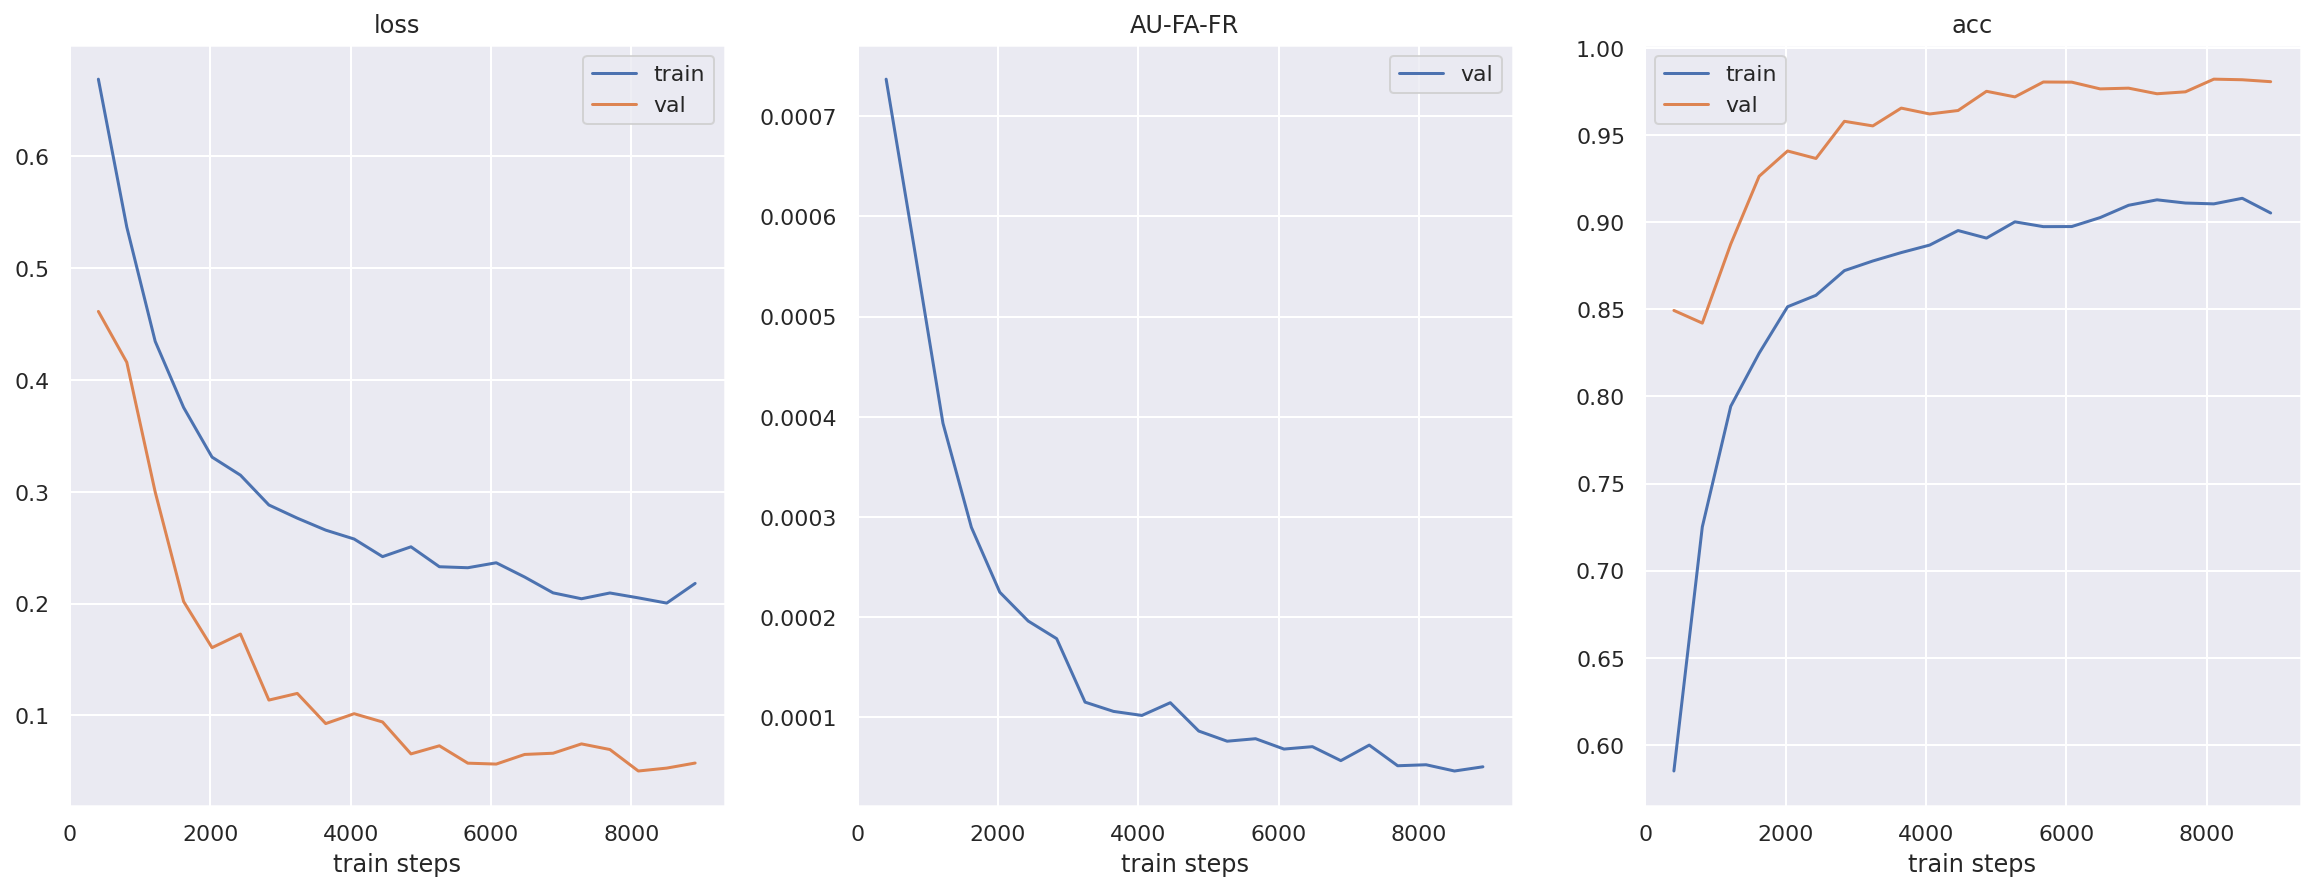

------------------------------------
Epoch 23/25


 34%|███▍      | 137/405 [00:12<00:23, 11.48it/s]

In [ ]:
baseline_trainer.train()

In [ ]:
baseline_trainer.save("baseline_run1")

# Baseline model

In [24]:
def get_baseline_model():
    baseline_config = TaskConfig(
        rnn_hidden_size=32,
    )
    baseline_model = CRNN(baseline_config)
    baseline_model.load_state_dict(torch.load(f'checkpoints/baseline_run1/model.pt', map_location=torch.device('cpu')))
    return baseline_model

# Dark knowledge distillation
> Попробуем применить дистилляцию к логитам с разными гиперпараметрами

In [ ]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    temperature: float = 10.
    alpha: float = 0.6
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    rnn_type: str = "gru"
    rnn_hidden_size: int = 64
    rnn_num_layers: int = 2
    rnn_dropout: float = 0.1
    rnn_bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')
    model_description: str = ""
    compression_info = {}

In [ ]:
class DistillationTrainer(Trainer):
    def __init__(self, config, model, *args, **kwargs):
        config.model_description = str(model)
        config.compression_info = evaluate_compression(get_baseline_model(), model.student)
        super().__init__(config, model, *args, **kwargs)
        self.temperature = config.temperature
        self.alpha = config.alpha

    def _process_batch(self, x_batch, y_batch, log_melspec, metrics, is_train):
        batch, labels = x_batch.to(self.device), y_batch.to(self.device)
        batch = log_melspec(batch)

        if is_train:
            self.optimizer.zero_grad()

        # run model # with autocast():
        teacher_logits, student_logits = self.model(batch)
        # we need probabilities so we use softmax & CE separately
        student_loss = F.cross_entropy(student_logits, labels)

        soft_teacher_probs = F.softmax(teacher_logits / self.temperature, dim=-1)
        soft_student_probs = F.softmax(student_logits / self.temperature, dim=-1)
        student_probs = F.softmax(student_logits, dim=-1)

        distillation_loss = F.mse_loss(soft_teacher_probs, soft_student_probs)

        loss = self.alpha * student_loss + (1. - self.alpha) * distillation_loss

        if is_train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 5)
            self.optimizer.step()

        argmax_probs = torch.argmax(student_probs, dim=-1)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

        metrics.update("loss", loss.item())
        metrics.update("acc", acc.item())
        
        return student_probs[:, 1].cpu()

## Trainable teacher
> Попробуем сделать учителя обучаемым

In [ ]:
class TrainableTeacherDistillationModel(nn.Module):
    def __init__(self, teacher, student):
        super().__init__()
        self.teacher = teacher
        self.student = student
    
    def forward(self, input):
        return self.teacher(input), self.student(input)

In [ ]:
teacher_config = TaskConfig(
    rnn_hidden_size=32,
)
student_config = TaskConfig(
    cnn_out_channels=4,
    rnn_hidden_size=16,
    rnn_num_layers=1,
    rnn_dropout=0.,
)

model = TrainableTeacherDistillationModel(CRNN(teacher_config), CRNN(student_config))

print(model)
print("Teacher parameters num:", count_model_parameters(model.teacher))
print("Student parameters num:", count_model_parameters(model.student))

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

distillation_trainer = DistillationTrainer(
    student_config,
    model,
    train_loader,
    val_loader,
    optimizer,
    use_wandb=True
)

DistillationModel(
  (teacher): CRNN(
    (conv): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
      (1): Flatten(start_dim=1, end_dim=2)
    )
    (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
    (attention): Attention(
      (energy): Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): Tanh()
        (2): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (classifier): Linear(in_features=32, out_features=2, bias=True)
  )
  (student): CRNN(
    (conv): Sequential(
      (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(2, 8))
      (1): Flatten(start_dim=1, end_dim=2)
    )
    (gru): GRU(72, 16, batch_first=True)
    (attention): Attention(
      (energy): Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): Tanh()
        (2): Linear(in_features=16, out_features=1, bias=True)
      )
    )
    (classifier): Linear(in_features=16, out_features=2, bias

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mak_corp. Use `wandb login --relogin` to force relogin


------------------------------------
Epoch 20/20
{
    "loss": 0.1662536878828649,
    "acc": 0.878221450617284,
    "loss_val": 0.09511754676407459,
    "acc_val": 0.9420144896881253,
    "AU-FA-FR_val": 0.00014594234364391284
}
------------------------------------



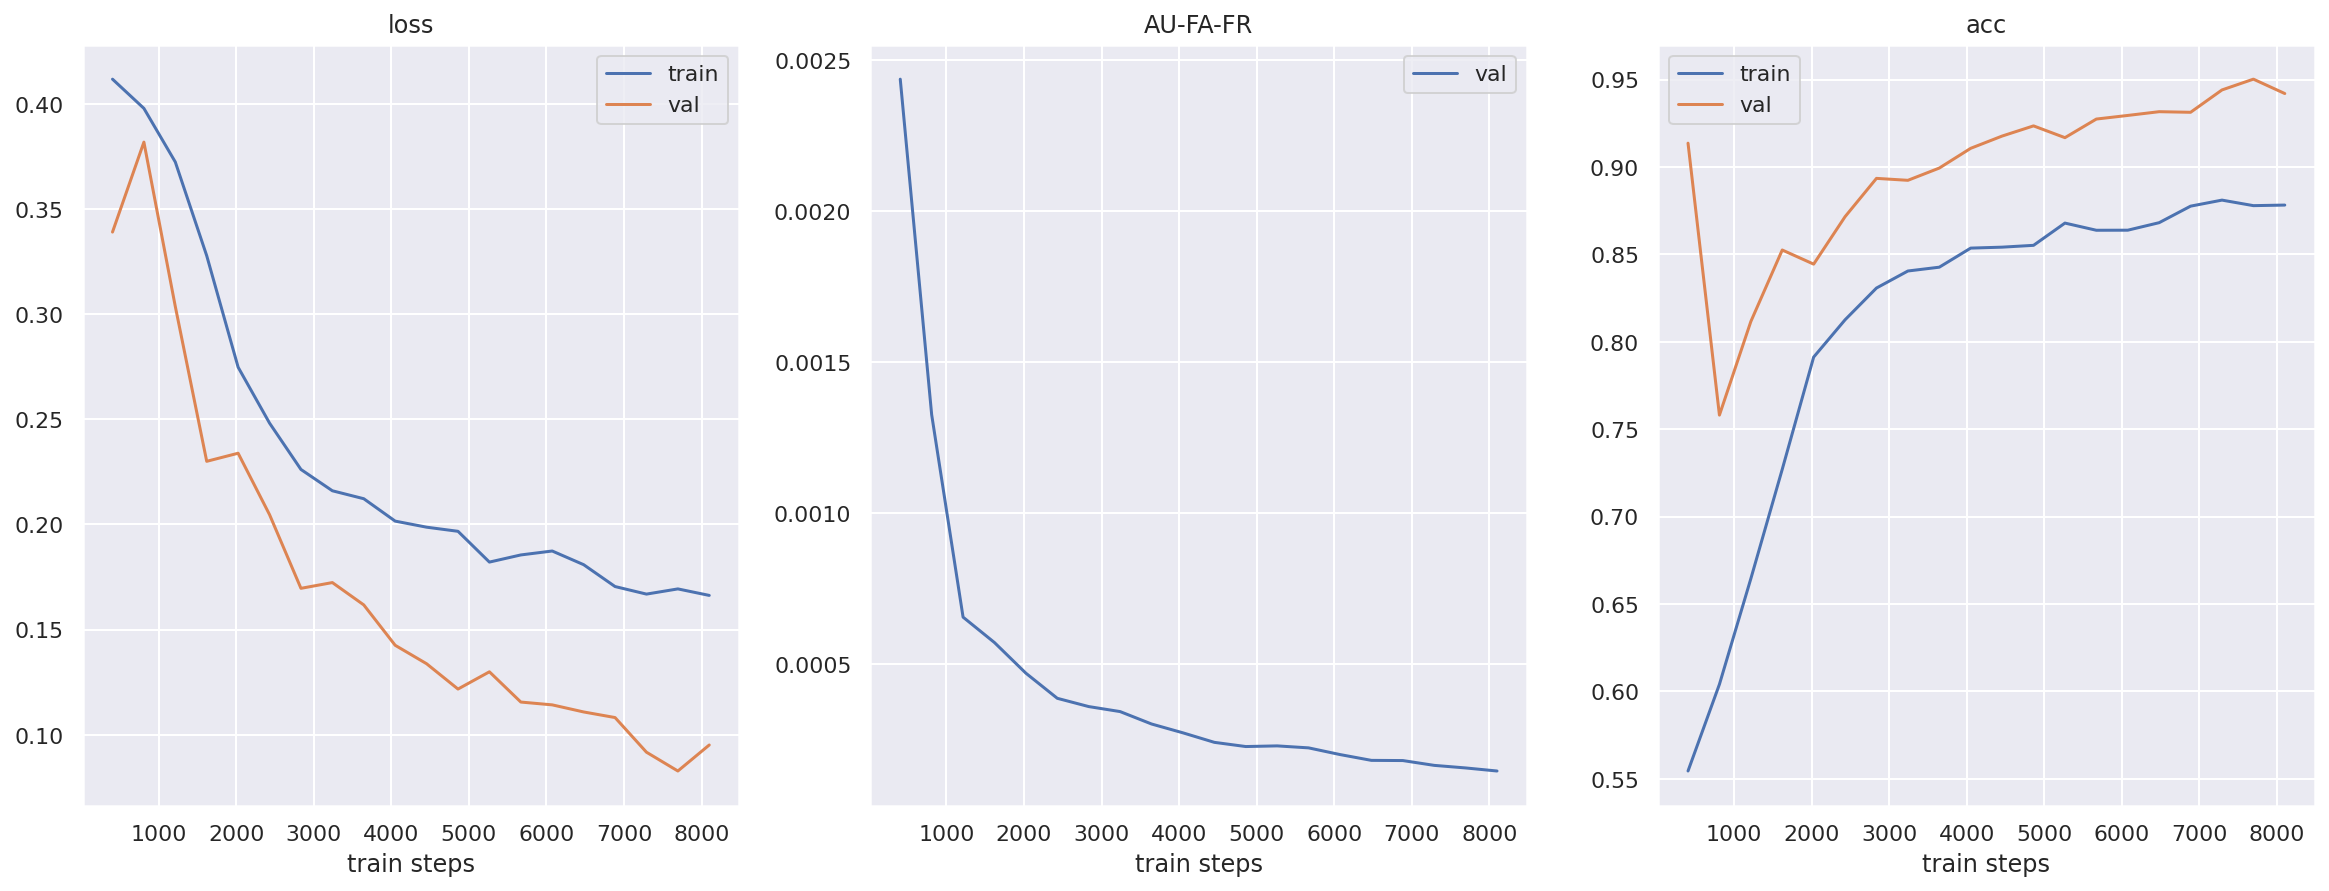

Finish training


In [ ]:
distillation_trainer.train()

In [ ]:
distillation_trainer.save("distillation_run2")

Saved checkpoint to checkpoints/distillation_run2


> В результате серии экспериментов оказалось, что преемлемого качества не добиться

## Trainable pretrained teacher
> Попробуем сначала предобучить учителя, а потом поместить его в дистилляцию, где учитель также учится

In [ ]:
teacher_config = TaskConfig(
    rnn_hidden_size=32,
)
teacher_model = CRNN(teacher_config)
teacher_model.load_state_dict(torch.load(f'checkpoints/baseline_run1/model.pt'))

<All keys matched successfully>

In [ ]:
student_config = TaskConfig(
    cnn_out_channels=4,
    rnn_hidden_size=32,
    rnn_num_layers=2,
    rnn_dropout=0.1,
    temperature=10,
    alpha=0.5,
    num_epochs=30,
    learning_rate=3e-4,
    kernel_size=(5,20),
    stride=(2,8),
)

model = TrainableTeacherDistillationModel(teacher_model, CRNN(student_config))

print(model)
print("Teacher parameters num:", count_model_parameters(model.teacher))
print("Student parameters num:", count_model_parameters(model.student))

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

distillation_trainer = DistillationTrainer(
    student_config,
    model,
    train_loader,
    val_loader,
    optimizer,
    use_wandb=True
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


TrainableTeacherDistillationModel(
  (teacher): CRNN(
    (conv): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
      (1): Flatten(start_dim=1, end_dim=2)
    )
    (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
    (attention): Attention(
      (energy): Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): Tanh()
        (2): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (classifier): Linear(in_features=32, out_features=2, bias=True)
  )
  (student): CRNN(
    (conv): Sequential(
      (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(2, 8))
      (1): Flatten(start_dim=1, end_dim=2)
    )
    (gru): GRU(72, 32, num_layers=2, batch_first=True, dropout=0.1)
    (attention): Attention(
      (energy): Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): Tanh()
        (2): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (classifier): 

AU-FA-FR_val,█▄▃▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc_train,▁▄▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████
acc_val,▁▅▅▇▆▆▇▇▇▇▇▇███▇████▇████████
epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
learning rate_train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_train,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
loss_val,█▄▄▂▃▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁
steps_per_sec_train,▁████▆████▆████████▇███▇▇███▇
steps_per_sec_val,▃███▇▇█▇██▇██▇▃████████▁▆█▇▆█
AU-FA-FR_val,0.00012
acc_train,0.92901


------------------------------------
Epoch 14/30
{
    "loss": 0.10896977698085485,
    "acc": 0.9056520061728395,
    "loss_val": 0.034895060629602154,
    "acc_val": 0.9747603085695529,
    "AU-FA-FR_val": 0.0001973348634125331
}
------------------------------------



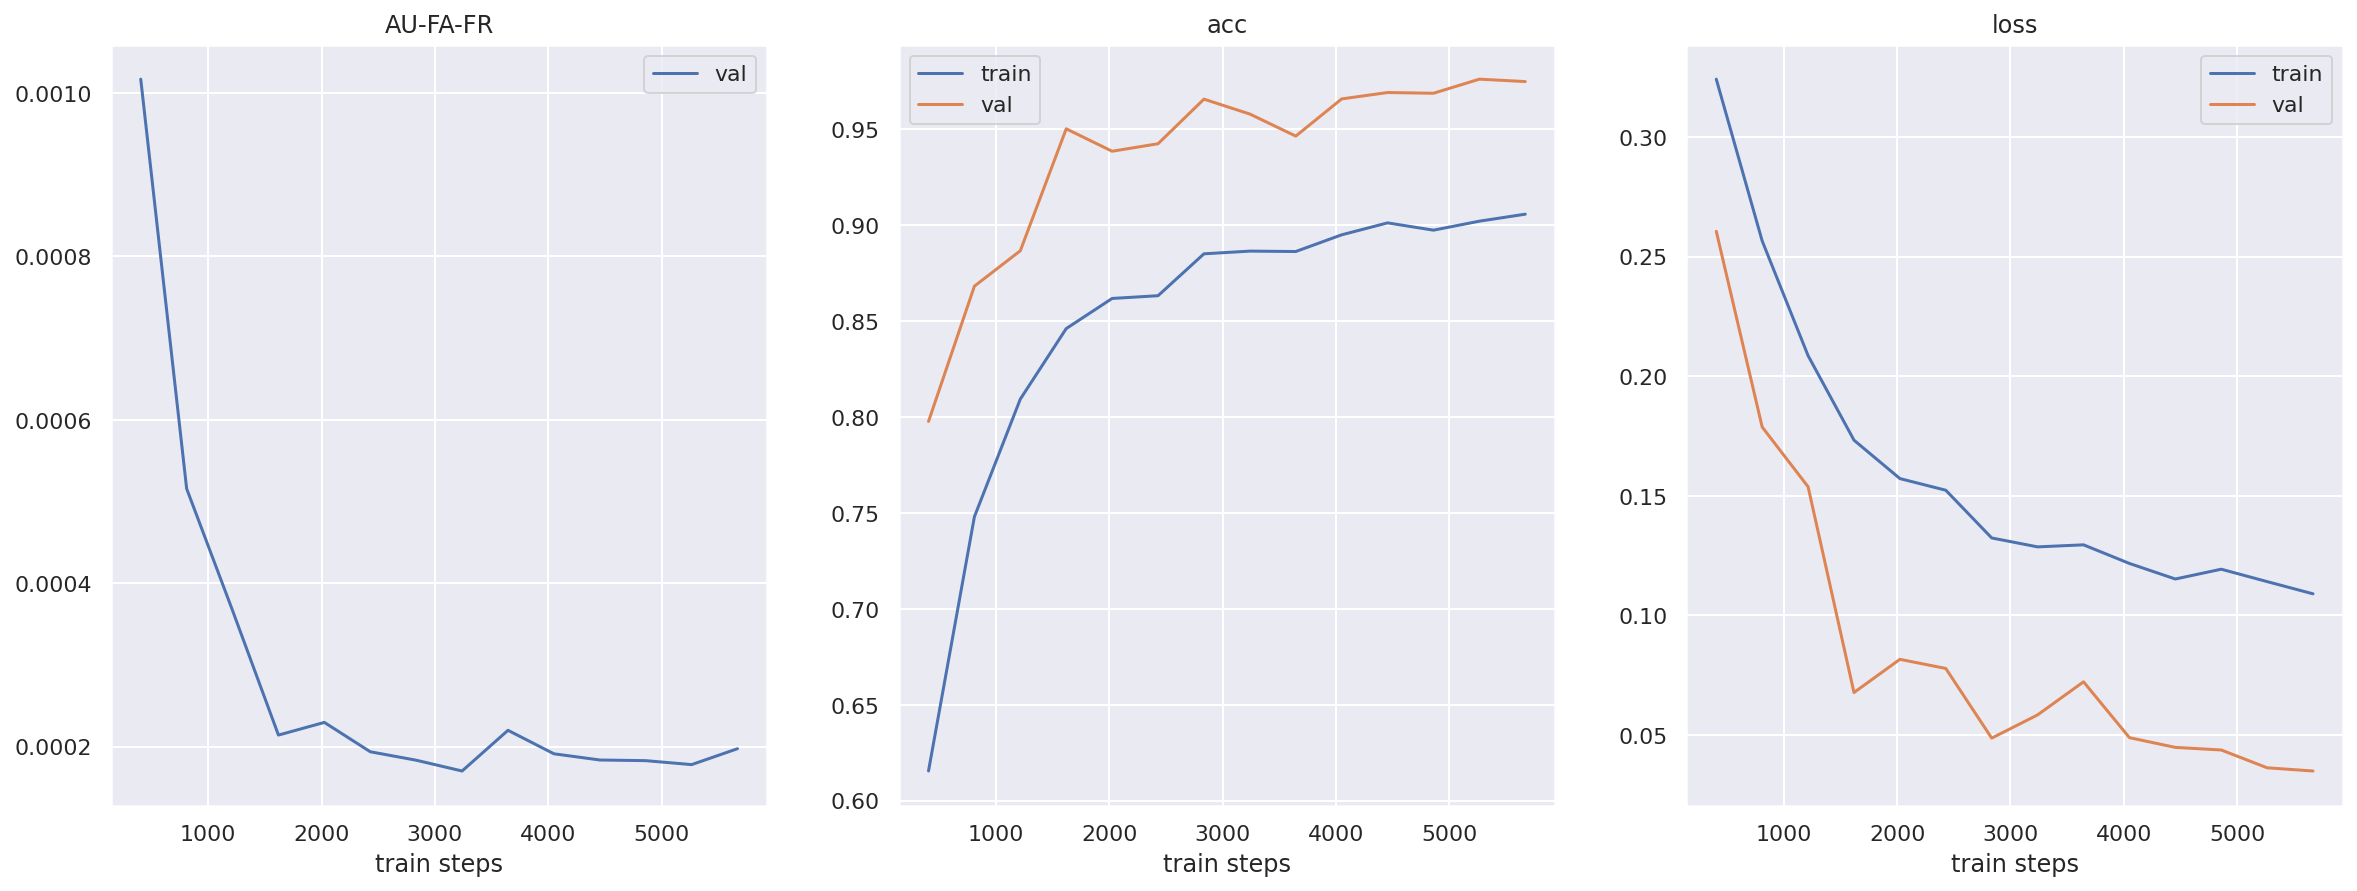

------------------------------------
Epoch 15/30


 14%|█▎        | 55/405 [00:05<00:33, 10.30it/s]


KeyboardInterrupt: ignored

In [ ]:
distillation_trainer.train()

In [ ]:
distillation_trainer.save("distillation_run3")

> Качество оказалось еще хуже. Вероятно, слишком большой lr просто испортил веса учителя.

## Pretrained teacher
> Зафиксируем веса учителя. Будем обучать только ученика.

In [ ]:
class PretrainedTeacherDistillationModel(nn.Module):
    def __init__(self, teacher, student):
        super().__init__()
        self.teacher = teacher.eval()
        self.student = student
    
    def forward(self, input):
        with torch.no_grad():
            teacher_logits = self.teacher(input)
        student_logits = self.student(input)
        return teacher_logits, student_logits

    def train(self):
        self.teacher.eval()
        self.student.train()

    def eval(self):
        self.teacher.eval()
        self.student.eval()

In [ ]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    temperature: float = 10.
    alpha: float = 0.6
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    rnn_type: str = "gru"
    rnn_hidden_size: int = 64
    rnn_num_layers: int = 2
    rnn_dropout: float = 0.1
    rnn_bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')
    model_description: str = ""
    compression_info = {}

In [ ]:
student_config = TaskConfig(
    learning_rate=3e-4
    cnn_out_channels=4,
    rnn_type="rnn",
    rnn_hidden_size=20,
    rnn_num_layers=2,

    temperature=10,
    alpha=0.005,

    num_epochs=30,
    kernel_size=(20,20),
    stride=(9,9),
)

model = PretrainedTeacherDistillationModel(get_baseline_model(), CRNN(student_config))

print(model)
print("Teacher parameters num:", count_model_parameters(model.teacher))
print("Student parameters num:", count_model_parameters(model.student))

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

pretrained_distillation_trainer = DistillationTrainer(
    student_config,
    model,
    train_loader,
    val_loader,
    optimizer,
    use_wandb=True
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


PretrainedTeacherDistillationModel(
  (teacher): CRNN(
    (conv): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
      (1): Flatten(start_dim=1, end_dim=2)
    )
    (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
    (attention): Attention(
      (energy): Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): Tanh()
        (2): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (classifier): Linear(in_features=32, out_features=2, bias=True)
  )
  (student): CRNN(
    (conv): Sequential(
      (0): Conv2d(1, 4, kernel_size=(20, 20), stride=(9, 9))
      (1): Flatten(start_dim=1, end_dim=2)
    )
    (gru): GRU(12, 20, num_layers=2, batch_first=True, dropout=0.1)
    (attention): Attention(
      (energy): Sequential(
        (0): Linear(in_features=20, out_features=20, bias=True)
        (1): Tanh()
        (2): Linear(in_features=20, out_features=1, bias=True)
      )
    )
    (classifier)

AU-FA-FR_val,█▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc_train,▁▂▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇█▇███████
acc_val,▆▂▁▃▅▄▆▄▆▆▆▆▆▇▇▆█▇▇▇██████
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
learning rate_train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_train,█▇▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
loss_val,█▇▆▄▃▄▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁
steps_per_sec_train,▁▇████▇██████████▇████▇███
steps_per_sec_val,▆▇█████████▁████████▆▇▇███
AU-FA-FR_val,0.00019
acc_train,0.83339


------------------------------------
Epoch 22/30
{
    "loss": 0.004906502807006976,
    "acc": 0.8398341049382716,
    "loss_val": 0.0037365692619727377,
    "acc_val": 0.9328638624911215,
    "AU-FA-FR_val": 0.00016244858025329557
}
------------------------------------



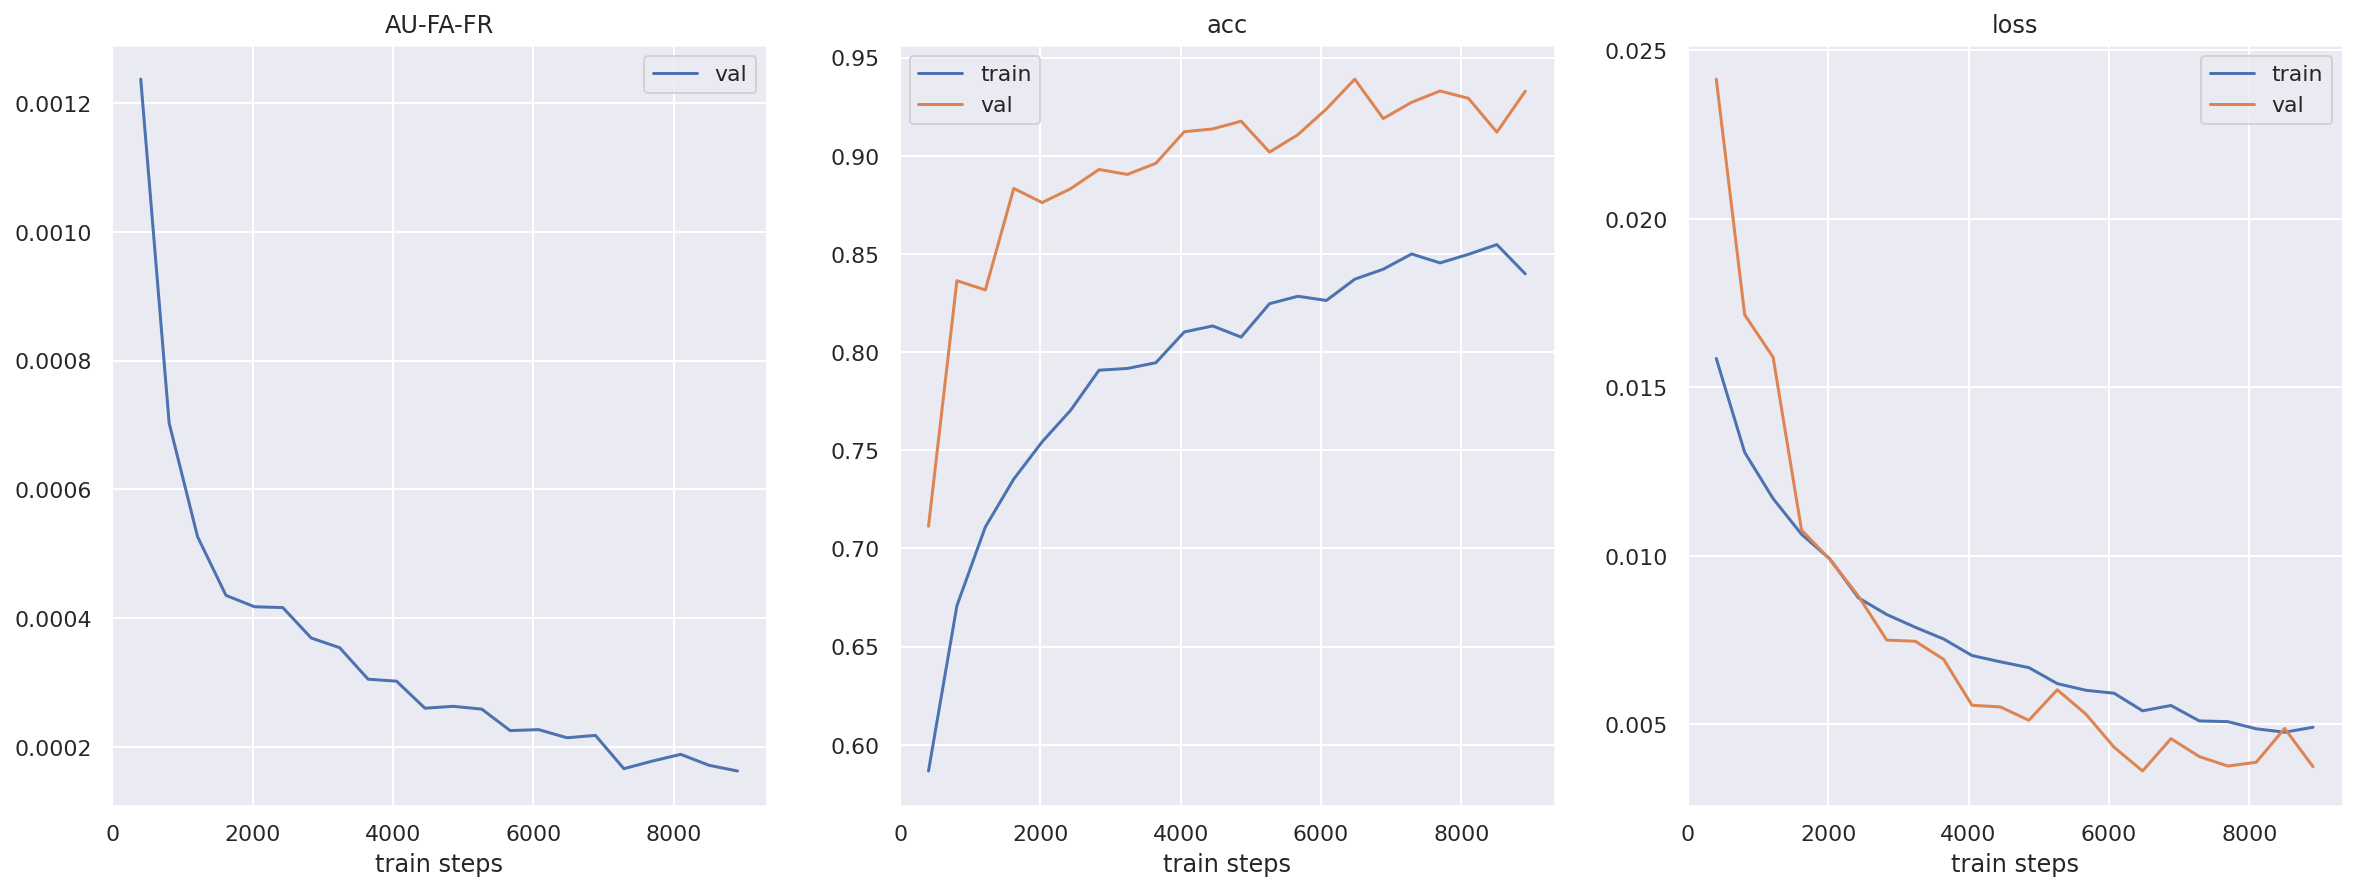

------------------------------------
Epoch 23/30


100%|██████████| 102/102 [00:06<00:00, 16.75it/s]


KeyboardInterrupt: ignored

In [ ]:
pretrained_distillation_trainer.train()

In [ ]:
pretrained_distillation_trainer.save("pretrained_distillation_run7")

Saved checkpoint to checkpoints/pretrained_distillation_run7


> Перепробовал много разных конфигураций. В результате получилось обучить с преемлемым качеством только очень несильно ужатые модели. 

#Layer-wise distillation

> Теперь применим дистилляцию не только к логитам. Навесим дистилляцию на каждый промежуточный выход.

In [25]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    temperature: float = 10
    conv_coef: float = 0.1
    rnn_coef: float = 0.2
    contex_coef: float = 0.3
    output_coef: float = 0.4
    label_coef: float = 0.1
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    rnn_type: str = "gru"
    rnn_hidden_size: int = 64
    rnn_num_layers: int = 2
    rnn_dropout: float = 0.1
    rnn_bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')
    model_description: str = ""
    compression_info = {}

In [114]:
class LayerWiseCRNN(nn.Module):
    def __init__(self, crnn, out_features):
        super().__init__()
        self.crnn = crnn
        self.conv_proj = nn.Linear(crnn.conv_out_size, out_features["conv_output"])
        self.rnn_proj = nn.Linear(crnn.gru.hidden_size, out_features["rnn_output"])
        self.contex_proj = nn.Linear(crnn.classifier.in_features, out_features["contex_vector"])

    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.crnn.conv(input).transpose(-1, -2)
        rnn_output, _ = self.crnn.gru(conv_output)
        contex_vector = self.crnn.attention(rnn_output)
        output = self.crnn.classifier(contex_vector)
        return {
            "conv_output": self.conv_proj(conv_output),
            "rnn_output": self.rnn_proj(rnn_output),
            "contex_vector": self.contex_proj(contex_vector),
            "output": output
        }

In [146]:
class LayerWiseDistillationModel(nn.Module):
    def __init__(self, teacher, student, out_features):
        super().__init__()
        self.teacher = LayerWiseCRNN(teacher, out_features).eval()
        self.student = LayerWiseCRNN(student, out_features)
        self.is_half = False
    
    def forward(self, input):
        with torch.no_grad():
            teacher_data = self.teacher(input)
        if self.is_half:
            teacher_data = {k: v.half() for k, v in teacher_data.items()}
            student_data = self.student(input.half())
            # print(student_data)
        else:
            student_data = self.student(input)

        return teacher_data, student_data

    def train(self):
        self.teacher.eval()
        self.student.train()

    def eval(self):
        self.teacher.eval()
        self.student.eval()

    def make_half(self):
        self.is_half = True
        self.student = self.student.half()

    def to(self, *args, **kwargs):
        new_model = super().to(*args, **kwargs)
        new_model.teacher = new_model.teacher.to(*args, **kwargs)
        new_model.student = new_model.student.to(*args, **kwargs)
        return new_model

In [147]:
class LayerWiseDistillationTrainer(Trainer):
    def __init__(self, config, model, *args, **kwargs):
        config.model_description = str(model)
        config.compression_info = evaluate_compression(
            get_baseline_model(),
            model.student.crnn,
            display=False
        )
        super().__init__(config, model, *args, **kwargs)

        self.conv_coef = config.conv_coef
        self.rnn_coef = config.rnn_coef
        self.contex_coef = config.contex_coef
        self.output_coef = config.output_coef
        self.label_coef = config.label_coef

    def _process_batch(self, x_batch, y_batch, log_melspec, metrics, is_train):
        batch, labels = x_batch.to(self.device), y_batch.to(self.device)
        batch = log_melspec(batch)

        if is_train:
            self.optimizer.zero_grad()

        # run model # with autocast():
        teacher_data, student_data = self.model(batch)
        # we need probabilities so we use softmax & CE separately

        student_probs = F.softmax(student_data["output"], dim=-1)

        conv_loss = F.mse_loss(teacher_data["conv_output"], student_data["conv_output"])
        rnn_loss = F.mse_loss(teacher_data["rnn_output"], student_data["rnn_output"])
        contex_loss = F.mse_loss(teacher_data["contex_vector"], student_data["contex_vector"])
        output_loss = F.mse_loss(teacher_data["output"], student_data["output"])
        student_loss = F.cross_entropy(student_data["output"], labels)

        loss = self.conv_coef * conv_loss + \
            self.rnn_coef * rnn_loss + \
            self.contex_coef * contex_loss + \
            self.output_coef * output_loss + \
            self.label_coef * student_loss

        # print(loss, conv_loss, rnn_loss, contex_loss, output_loss, student_loss)

        # print(teacher_data["conv_output"])
        # print(student_data["conv_output"])
        # print()

        if is_train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 5)
            self.optimizer.step()

        argmax_probs = torch.argmax(student_probs, dim=-1)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

        metrics.update("loss", loss.item())
        metrics.update("acc", acc.item())
        
        return student_probs[:, 1].cpu()

## Run

In [272]:
student_config = TaskConfig(
    learning_rate=3e-4,
    cnn_out_channels=3,
    kernel_size=(5,20),
    stride=(5,8),
    rnn_type="gru",
    rnn_hidden_size=16,
    rnn_num_layers=1,
    num_epochs=40,
)

out_features = {
    "conv_output": 24,
    "rnn_output": 16,
    "contex_vector": 16,
}
model = LayerWiseDistillationModel(
    get_baseline_model(),
    CRNN(student_config),
    out_features=out_features,
)

print(model)
print()
evaluate_compression(get_baseline_model(), model.student.crnn)
print()

LayerWiseDistillationModel(
  (teacher): LayerWiseCRNN(
    (crnn): CRNN(
      (conv): Sequential(
        (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
        (1): Flatten(start_dim=1, end_dim=2)
      )
      (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
      (attention): Attention(
        (energy): Sequential(
          (0): Linear(in_features=32, out_features=32, bias=True)
          (1): Tanh()
          (2): Linear(in_features=32, out_features=1, bias=True)
        )
      )
      (classifier): Linear(in_features=32, out_features=2, bias=True)
    )
    (conv_proj): Linear(in_features=144, out_features=24, bias=True)
    (rnn_proj): Linear(in_features=32, out_features=16, bias=True)
    (contex_proj): Linear(in_features=32, out_features=16, bias=True)
  )
  (student): LayerWiseCRNN(
    (crnn): CRNN(
      (conv): Sequential(
        (0): Conv2d(1, 3, kernel_size=(5, 20), stride=(5, 8))
        (1): Flatten(start_dim=1, end_dim=2)
      )
      (gru

In [273]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

layer_wise_distillation_trainer = LayerWiseDistillationTrainer(
    student_config,
    model,
    train_loader,
    val_loader,
    optimizer,
    use_wandb=False
)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


------------------------------------
Epoch 40/40
{
    "loss": 0.3480067562909774,
    "acc": 0.8910686728395062,
    "loss_val": 0.3232647363169521,
    "acc_val": 0.9575674019607843,
    "AU-FA-FR_val": 5.198927452673245e-05
}
------------------------------------



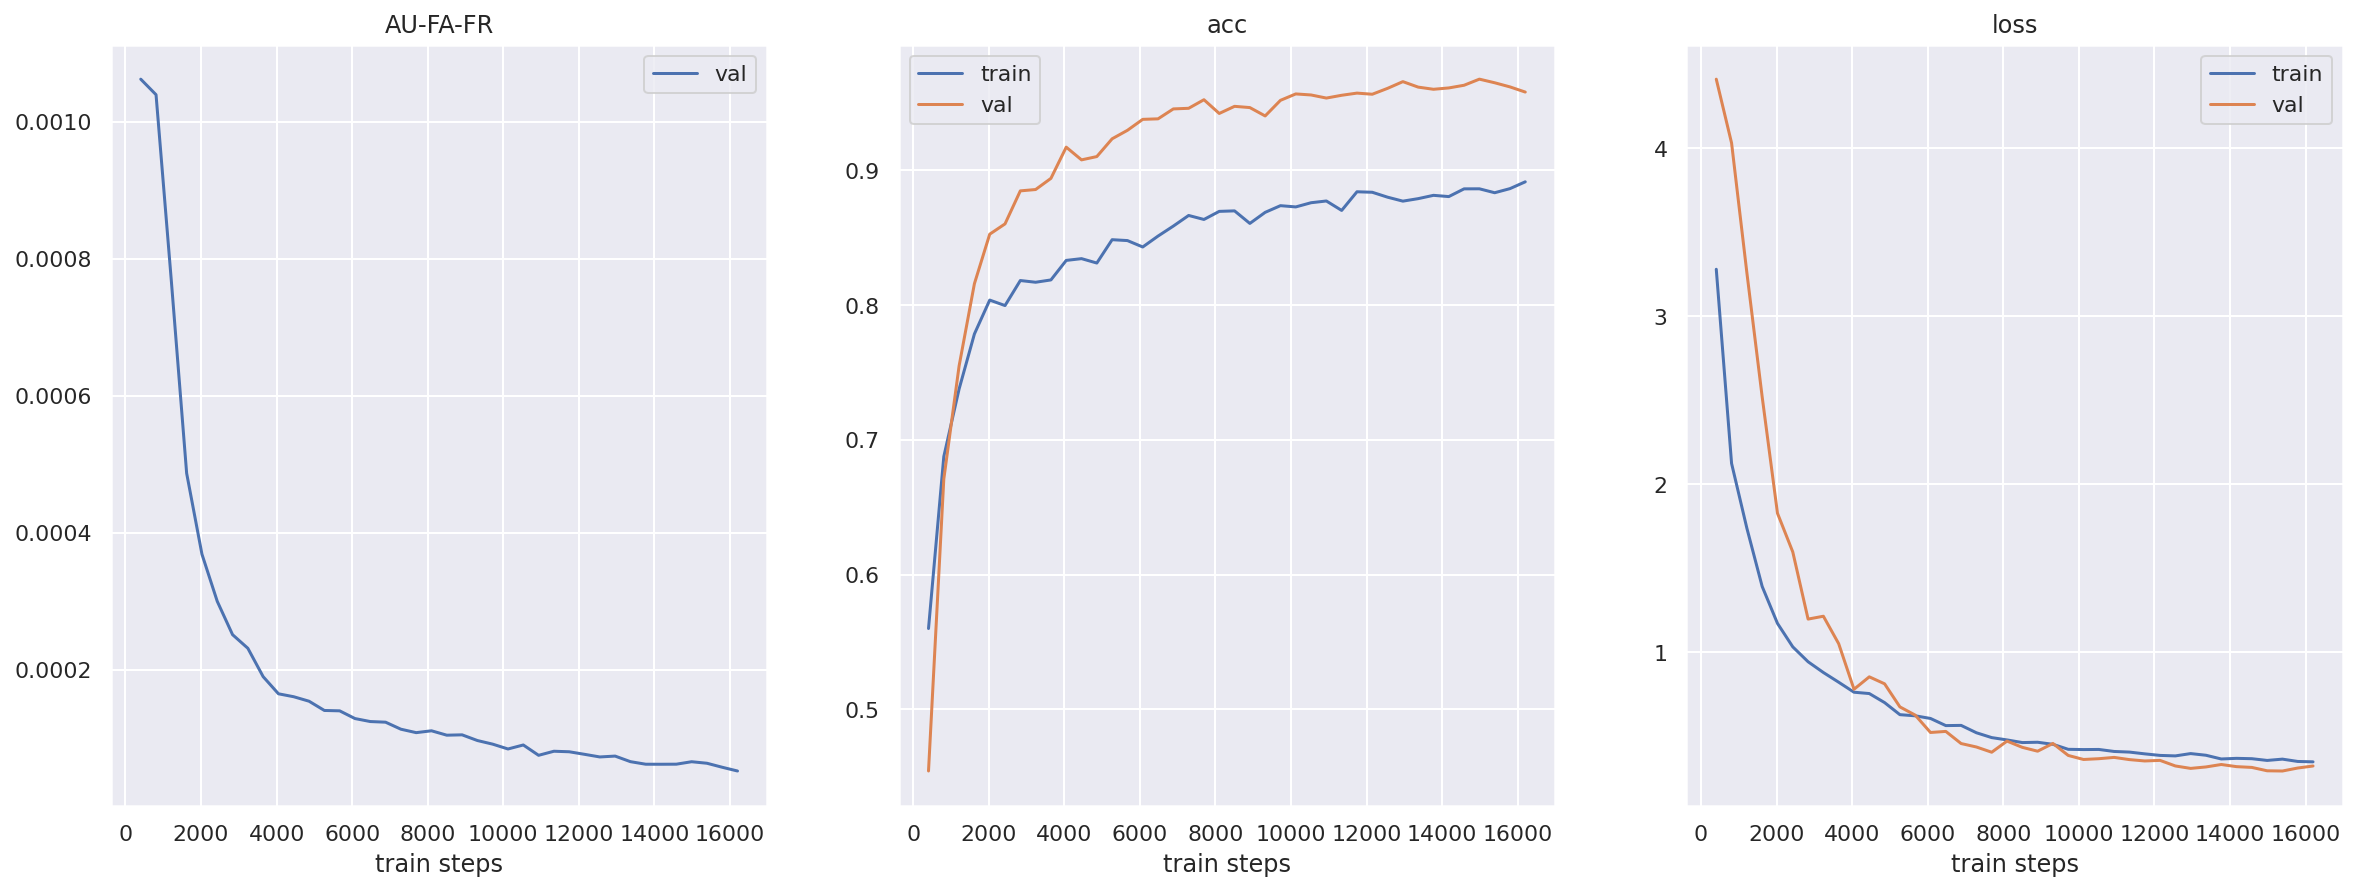

Finish training


In [ ]:
layer_wise_distillation_trainer.train()

In [154]:
# layer_wise_distillation_trainer.save("layerwise_distillation_run6")

Saved checkpoint to checkpoints/layerwise_distillation_run5_filtered


In [274]:
layer_wise_distillation_trainer.load("layerwise_distillation_run5_filtered")

Loaded checkpoint from checkpoints/layerwise_distillation_run5_filtered


100%|██████████| 102/102 [00:05<00:00, 17.56it/s]


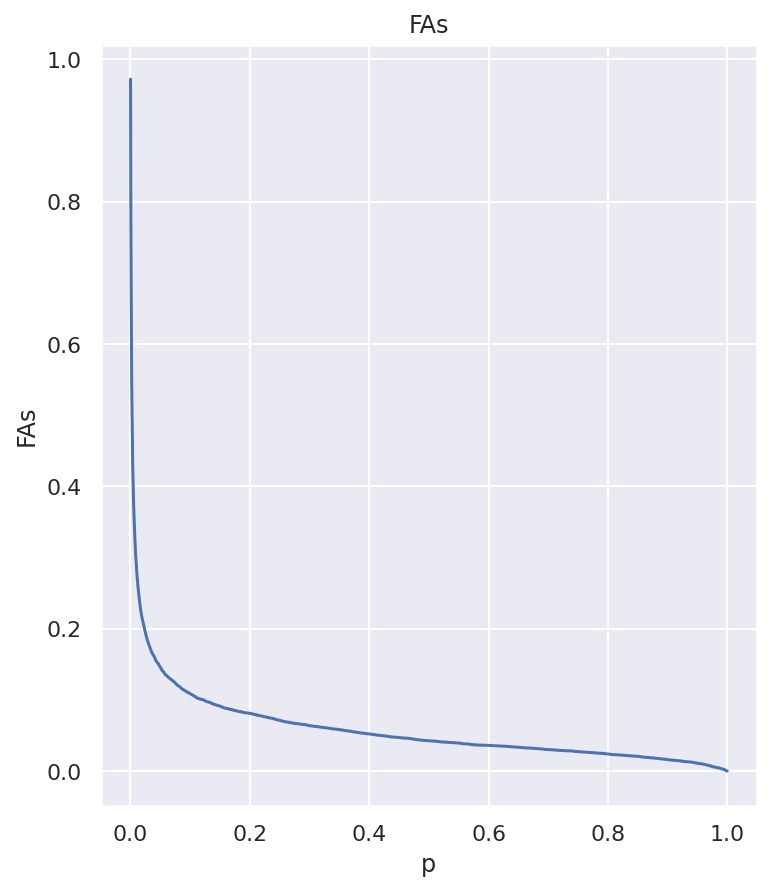

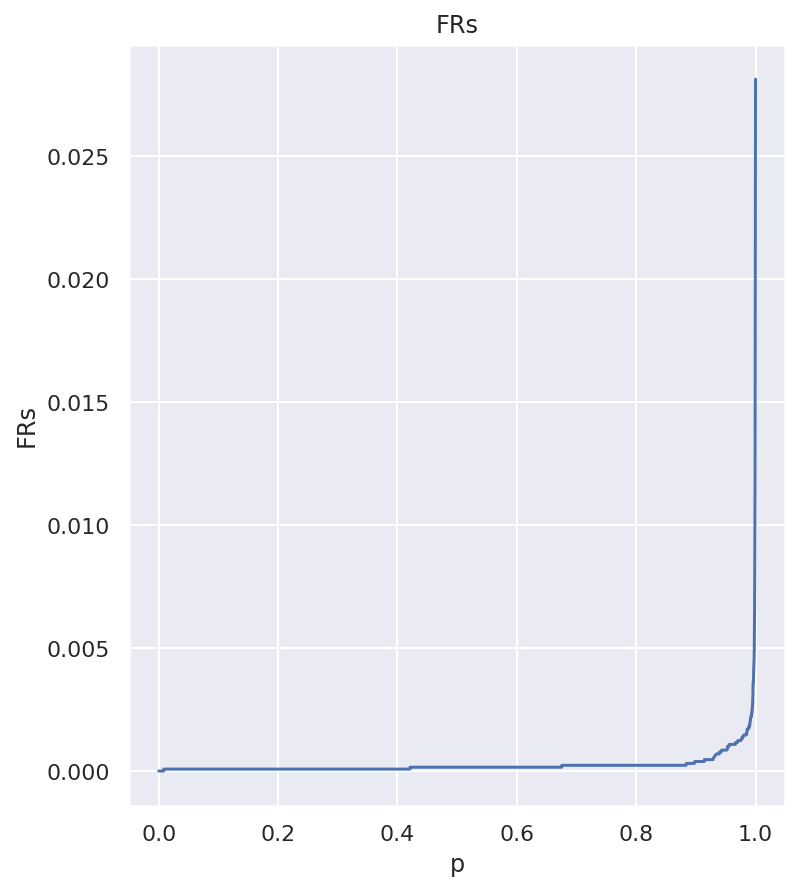

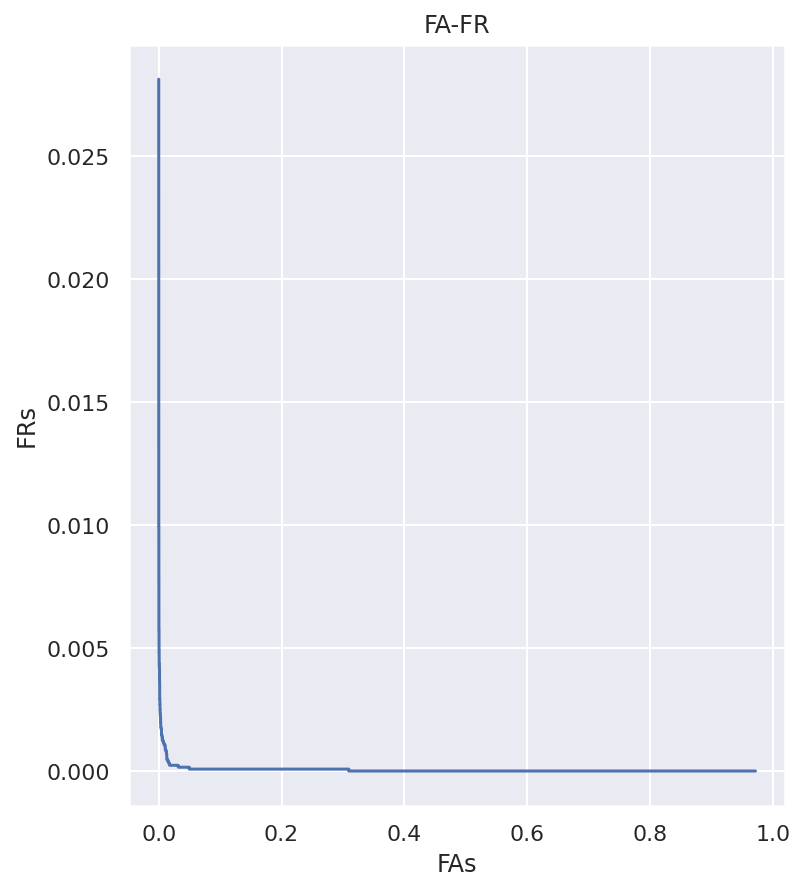

{'loss': 0.3232647363169521,
 'acc': 0.9575674019607843,
 'AU-FA-FR': 5.198927452673245e-05}

In [275]:
layer_wise_distillation_trainer.model.to(config.device)
layer_wise_distillation_trainer.validate(plot_fa_fr=True)

> В результате подбора гиперпараметров получилось хорошо ужать модель. Это мой лучший результат в fp32.

## Best model

In [169]:
def get_fp32_compressed_model():
    student_config = TaskConfig(
        learning_rate=3e-4,
        cnn_out_channels=3,
        kernel_size=(5,20),
        stride=(5,8),
        rnn_type="gru",
        rnn_hidden_size=16,
        rnn_num_layers=1,
        num_epochs=40,
    )

    out_features = {
        "conv_output": 24,
        "rnn_output": 16,
        "contex_vector": 16,
    }
    model = LayerWiseDistillationModel(
        get_baseline_model(),
        CRNN(student_config),
        out_features=out_features,
    )
    model.load_state_dict(torch.load(f'checkpoints/layerwise_distillation_run5_filtered/model.pt', map_location=torch.device('cpu')))
    return model

def get_fp32_compressed_crnn():
    model = get_fp16_compressed_model()
    return model.student.crnn

# Quantization

> Теперь попробуем применить квантизацию до fp16 на лучшую модель в fp32.

In [156]:
model = get_fp32_compressed_model()
model.make_half()

print(model)
print()
evaluate_compression(get_baseline_model(), model.student.crnn)
print()

LayerWiseDistillationModel(
  (teacher): LayerWiseCRNN(
    (crnn): CRNN(
      (conv): Sequential(
        (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
        (1): Flatten(start_dim=1, end_dim=2)
      )
      (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
      (attention): Attention(
        (energy): Sequential(
          (0): Linear(in_features=32, out_features=32, bias=True)
          (1): Tanh()
          (2): Linear(in_features=32, out_features=1, bias=True)
        )
      )
      (classifier): Linear(in_features=32, out_features=2, bias=True)
    )
    (conv_proj): Linear(in_features=144, out_features=24, bias=True)
    (rnn_proj): Linear(in_features=32, out_features=16, bias=True)
    (contex_proj): Linear(in_features=32, out_features=16, bias=True)
  )
  (student): LayerWiseCRNN(
    (crnn): CRNN(
      (conv): Sequential(
        (0): Conv2d(1, 3, kernel_size=(5, 20), stride=(5, 8))
        (1): Flatten(start_dim=1, end_dim=2)
      )
      (gru

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


> Лучшая модель ужалась в 11.83 раз по памяти и в 8.19 раз по флопсам.

In [157]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

layer_wise_fp16_distillation_trainer = LayerWiseDistillationTrainer(
    student_config,
    model,
    train_loader,
    val_loader,
    optimizer,
    use_wandb=False
)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


In [158]:
layer_wise_fp16_distillation_trainer.model.to(config.device)
layer_wise_fp16_distillation_trainer.validate()

100%|██████████| 102/102 [00:05<00:00, 17.52it/s]


{'loss': 0.3232625325520833,
 'acc': 0.957797181372549,
 'AU-FA-FR': 5.225184662030181e-05}

In [159]:
# layer_wise_fp16_distillation_trainer.save("layerwise_fp16_distillation_run1")

Saved checkpoint to checkpoints/layerwise_fp16_distillation_run1


> Как видим, качество модели не просело, хотя по памяти мы еще лучше ужались.

##Best model

In [161]:
def get_fp16_compressed_model():
    model = get_fp32_compressed_model()
    model.load_state_dict(torch.load(f'checkpoints/layerwise_fp16_distillation_run1/model.pt', map_location=torch.device('cpu')))
    return model

def get_fp16_compressed_crnn():
    model = get_fp16_compressed_model()
    return model.student.crnn

#По мотивам экспериментов построим графики Metric-Flops и Metric-Memory

In [340]:
experiments = pd.DataFrame([
    ("gentle-sound-32", 0.0001894, 243425, 0.0450, "Logits distillation"),
    ("fluent-flower-33", 0.0001624, 211300, 0.0295, "Logits distillation"),
    ("layerwise_distillation_run1", 0.00004838, 604272, 0.0831, "CNN layers=4"),
    ("layerwise_distillation_run2", 0.00005408, 346576, 0.0409, "rnn_hidden_size=16"),
    ("layerwise_distillation_run3", 0.00005311, 177776, 0.0248, "stride=(5,8)"),
    ("layerwise_distillation_run4", 0.00005253, 137664, 0.0174, "rnn_num_layers=1"),
    ("layerwise_distillation_run5", 0.00005199, 110432, 0.0156, "CNN layers=3"),
    ("layerwise_fp16_distillation_run1", 0.00005225, 110432, 0.0085, "FP16 quantization"),
], columns=["name", "metric", "macs", "memory", "description"])
experiments

,name,metric,macs,memory,description
0,gentle-sound-32,0.000189,243425,0.0450,Logits distillation
1,fluent-flower-33,0.000162,211300,0.0295,Logits distillation
2,layerwise_distillation_run1,0.000048,604272,0.0831,CNN layers=4
3,layerwise_distillation_run2,0.000054,346576,0.0409,rnn_hidden_size=16
4,layerwise_distillation_run3,0.000053,177776,0.0248,"stride=(5,8)"
5,layerwise_distillation_run4,0.000053,137664,0.0174,rnn_num_layers=1
6,layerwise_distillation_run5,0.000052,110432,0.0156,CNN layers=3
7,layerwise_fp16_distillation_run1,0.000052,110432,0.0085,FP16 quantization


In [344]:
experiments['macs'][0]

243425

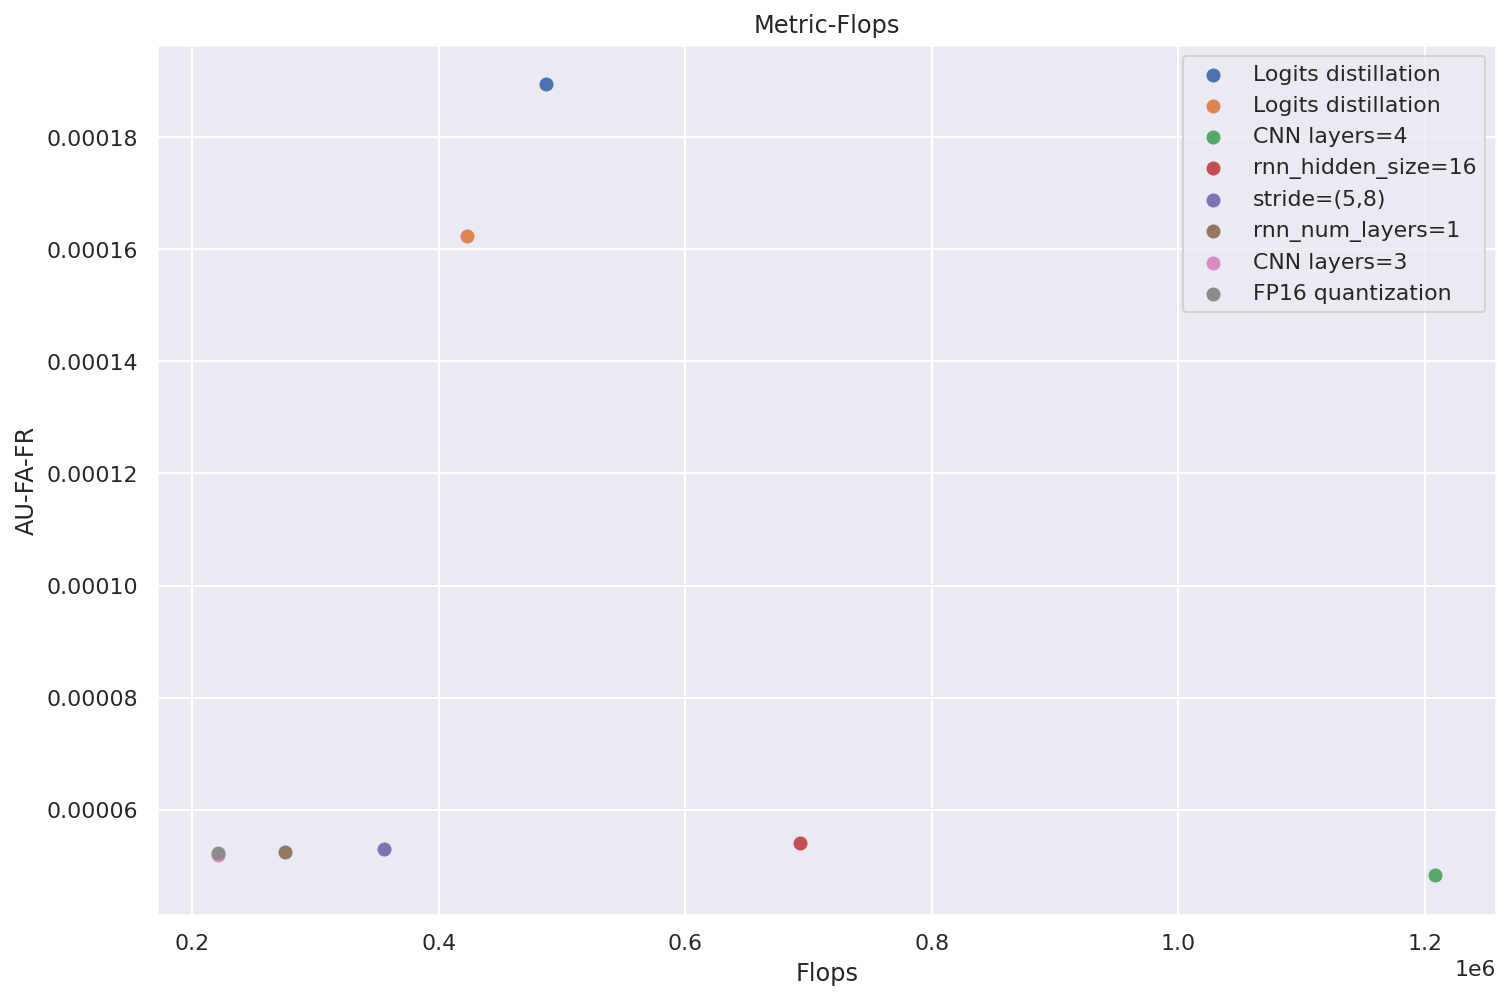

In [347]:
plt.figure(figsize=(12,8))
plt.title("Metric-Flops")
for i in range(len(experiments)):
    plt.scatter(experiments["macs"][i] * 2, experiments["metric"][i], label=experiments['description'][i])
plt.xlabel("Flops")
plt.ylabel("AU-FA-FR")
plt.legend()
print()

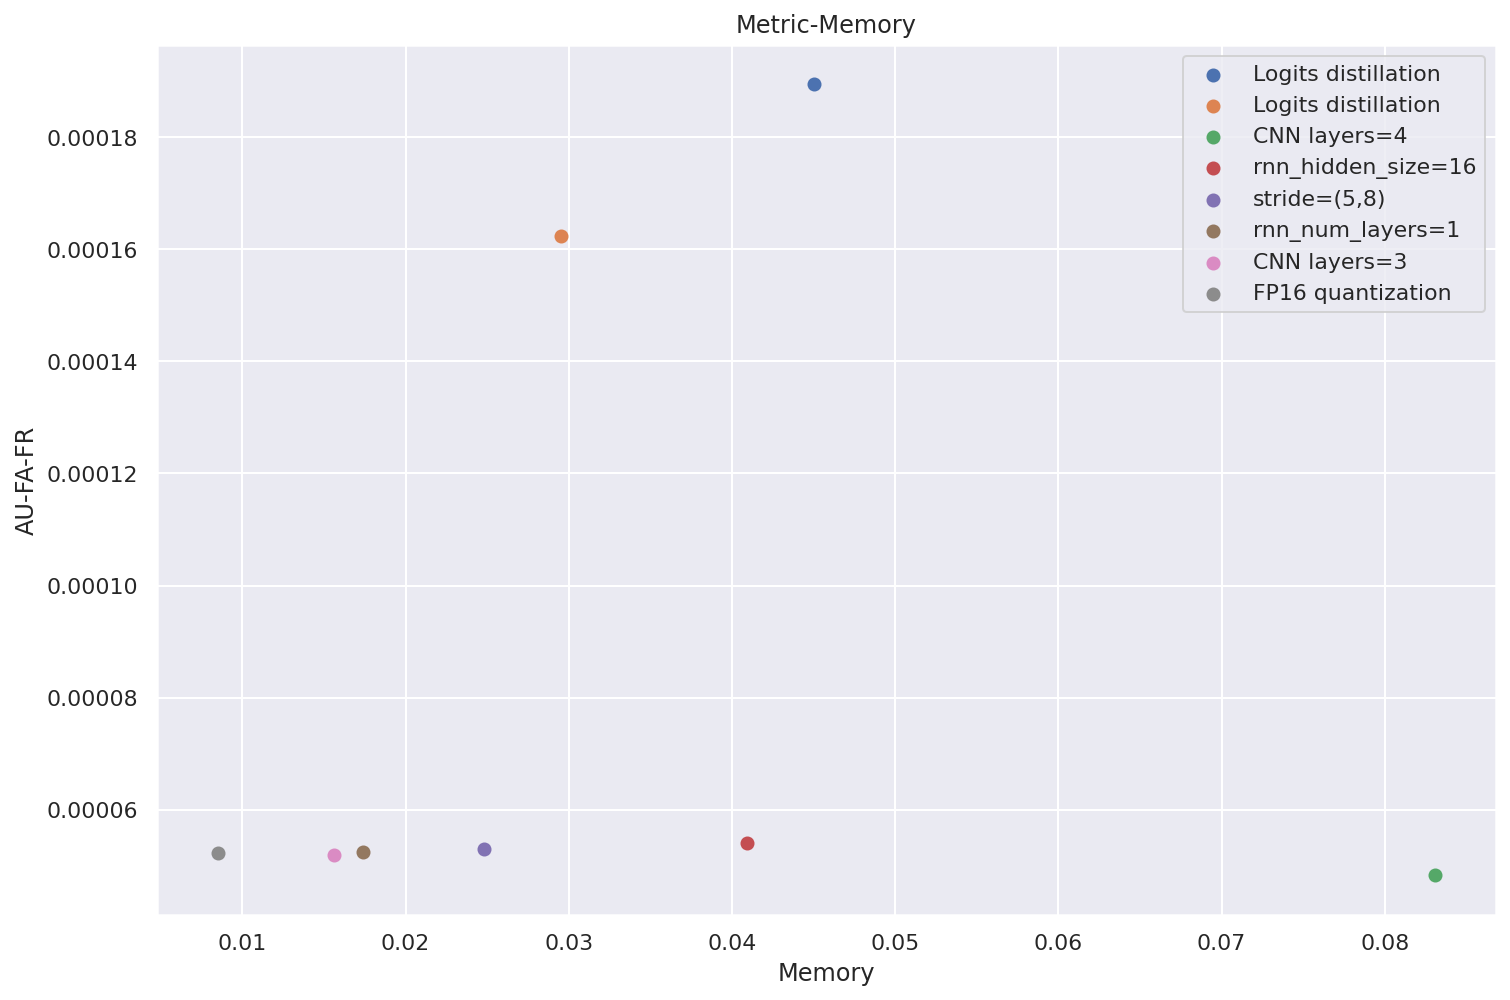

In [349]:
plt.figure(figsize=(12,8))
plt.title("Metric-Memory")
for i in range(len(experiments)):
    plt.scatter(experiments["memory"][i], experiments["metric"][i], label=experiments['description'][i])
plt.xlabel("Memory")
plt.ylabel("AU-FA-FR")
plt.legend()
print()

#Streaming
> Теперь реализуем стриминг. Будем применять мел-спектрограмму к последней и предпосленей вавке. Потом к ним применять свертку. Потом оставлять только временной промежуток от последней вавки. Далее загоним это в GRU, начнем с hidden с предыдущих итераций. После применим Attention к сохраненному окну из выходов GRU. Наконец, применим классификатор.

In [312]:
class LogMelspecModule(nn.Module):
    def __init__(self, sample_rate, n_mels, is_train):
        super().__init__()
        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=400,
            win_length=400,
            hop_length=160,
            n_mels=n_mels
        )

    def forward(self, input):
        return torch.log(self.melspec(input).clamp_(min=1e-9, max=1e9))


class OneChunkStreamingCRNN(nn.Module):

    def __init__(self, config: TaskConfig, crnn):
        super().__init__()

        self.mel = LogMelspecModule(config.sample_rate, config.n_mels, is_train=False)
        self.crnn = crnn.cpu()
    
    def forward(self, chunk):
        mel = self.mel(chunk)
        logits = self.crnn(mel)
        probs = F.softmax(logits, dim=-1)
        return probs[:, 1]


class StreamingCRNN(nn.Module):

    def __init__(self, config: TaskConfig, crnn, max_window_length):
        super().__init__()

        self.mel = LogMelspecModule(config.sample_rate, config.n_mels, is_train=False)
        self.crnn = crnn.cpu()

        self.max_window_length = max_window_length
        self.window = list()
        self.last_rnn_hidden = None

        self.last_chunk = None
    
    def forward(self, chunk):
        if self.last_chunk is not None:
            glued = torch.cat([self.last_chunk, chunk], dim=1)
        else:
            glued = chunk

        mel = self.mel(glued).unsqueeze(dim=1)
        conv_output = self.crnn.conv[0](mel)
        
        if self.last_chunk is not None:
            time = conv_output.shape[-1] // 2
            conv_output = conv_output[:,:,:,time:]
        
        conv_output = self.crnn.conv[1](conv_output).transpose(-1, -2)
        self.last_chunk = chunk

        mel = self.mel(chunk).unsqueeze(dim=1)
        conv_output = self.crnn.conv(mel).transpose(-1, -2)
        rnn_output, self.last_rnn_hidden = self.crnn.gru(conv_output, self.last_rnn_hidden)

        self.window.append(rnn_output)
        if len(self.window) > self.max_window_length:
            self.window = self.window[1:]
        
        rnn_window_output = torch.cat(self.window, dim=1)
        contex_vector = self.crnn.attention(rnn_window_output)
        logits = self.crnn.classifier(contex_vector)
        probs = F.softmax(logits, dim=-1)
        return probs[:, 1]

    def on_word_found(self):
        self.last_rnn_hidden = None

### One chunk model
> Протестируем на одном чанке.

In [248]:
one_chunk_model = OneChunkStreamingCRNN(config, get_fp32_compressed_crnn())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [249]:
with torch.no_grad():
    output = one_chunk_model(torch.randn(1, 16000 * 2))
output

tensor([0.0573])

In [250]:
torch.jit.save(torch.jit.script(one_chunk_model), "checkpoints/one_chunk_kws.pth")

### Streaming model
> Визуализируем вероятность ключевого слова на записи из шума, слова и шума.

In [292]:
import IPython.display as ipd

keyword_wav, sr = torchaudio.load("/content/speech_commands/sheila/004ae714_nohash_0.wav")
keyword_wav = keyword_wav.squeeze()
ipd.Audio(keyword_wav, rate=sr)

In [284]:
left_wav, sr = torchaudio.load("/content/speech_commands/_background_noise_/dude_miaowing.wav")
left_wav = left_wav[0, :sr*10]
ipd.Audio(left_wav, rate=sr)

In [285]:
right_wav, sr = torchaudio.load("/content/speech_commands/_background_noise_/exercise_bike.wav")
right_wav = right_wav[0, :sr*11]
ipd.Audio(right_wav, rate=sr)

In [296]:
glued_wav = torch.cat([left_wav, keyword_wav, right_wav], dim=0)
glued_wav.shape

torch.Size([352000])

In [302]:
chunks = glued_wav.split(4000)
len(chunks)

88

In [313]:
streaming_model = StreamingCRNN(config, get_fp32_compressed_crnn(), max_window_length=20).eval()

In [314]:
probs = []
seconds = []

timing = 0.
for chunk in chunks:
    with torch.no_grad():
        timing += chunk.shape[0] / 16000
        seconds.append(timing)
        prob = streaming_model(chunk.unsqueeze(0))
        probs.append(prob)

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


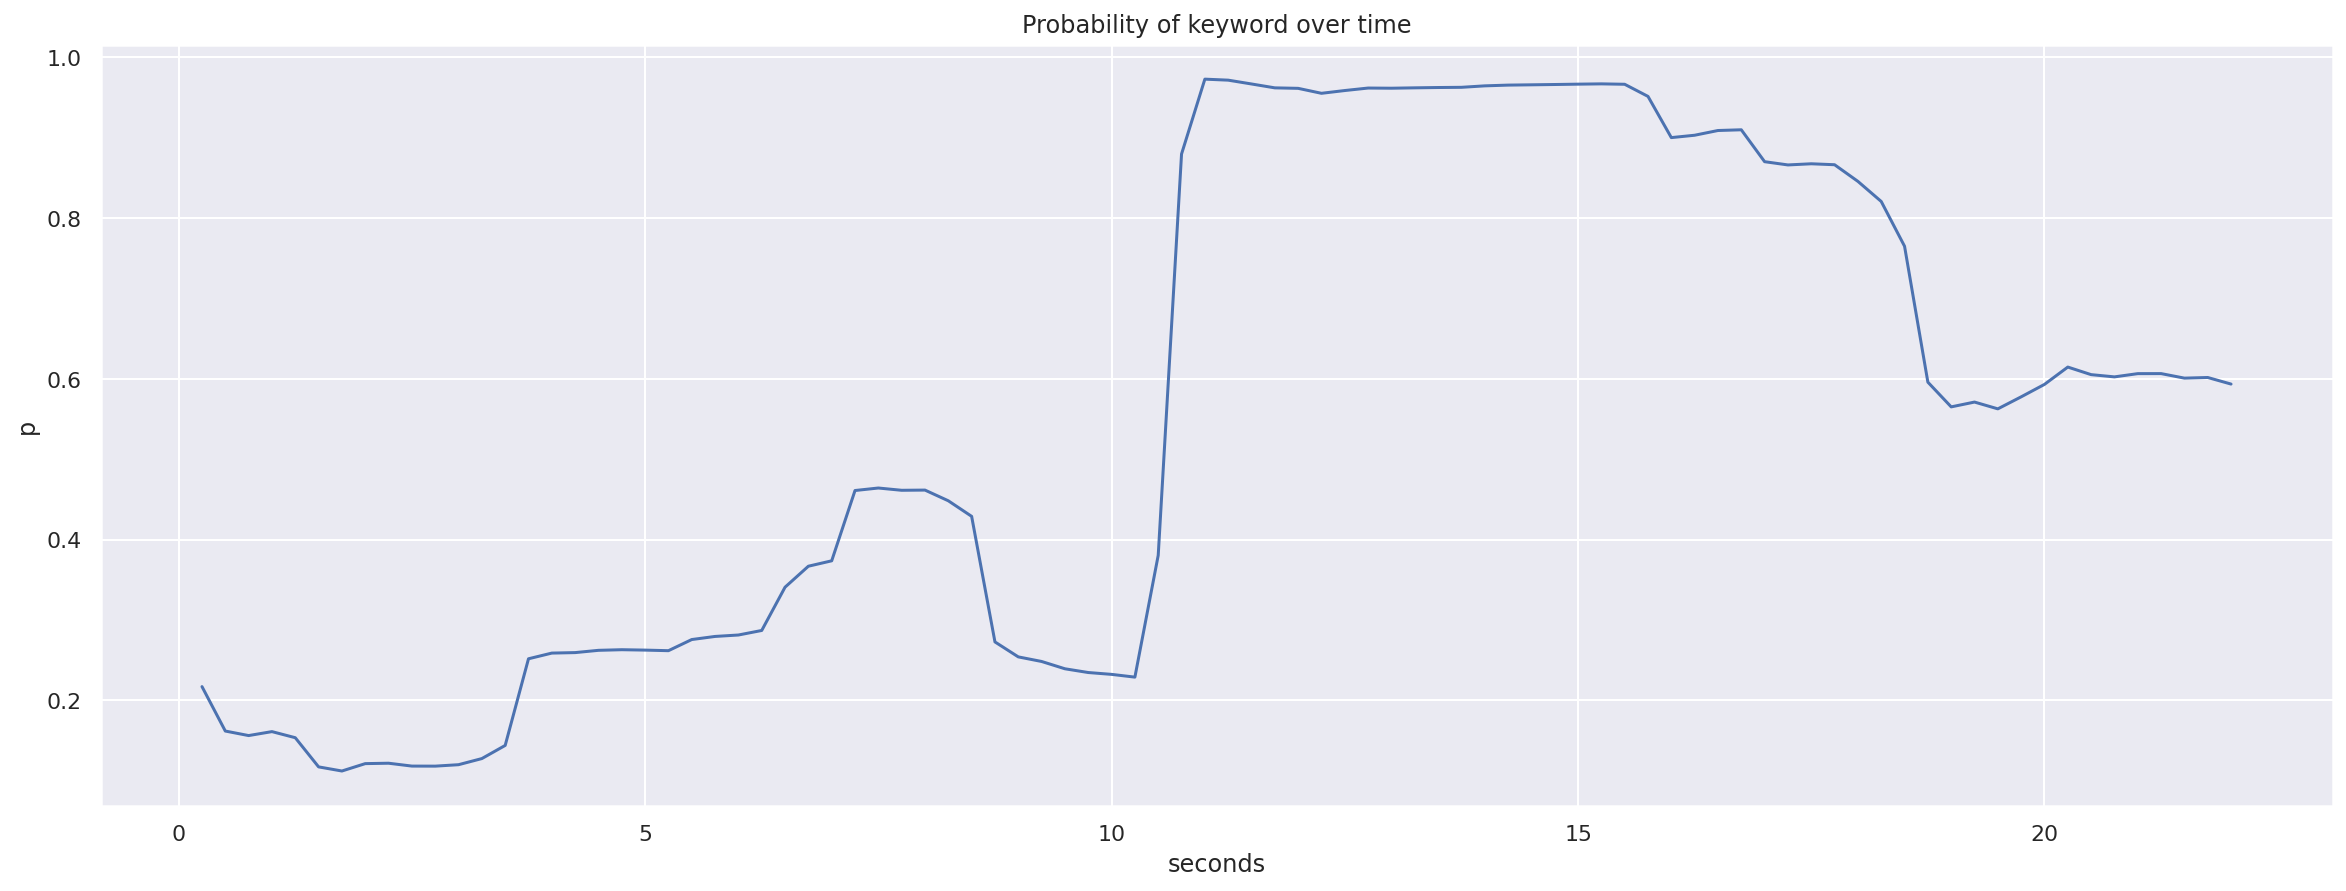

In [315]:
plt.title("Probability of keyword over time")
plt.plot(seconds, probs)
plt.xlabel("seconds")
plt.ylabel("p")
print()

In [316]:
torch.jit.save(torch.jit.script(streaming_model), "checkpoints/kws_compressed.pth")